## Домашнее задание 

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). 

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.

# Урок 5. Случайный лес

### Out-of-Bag

Вспомним, что каждое дерево $b_{n}$, составляющее случайный лес, строится на основе бутстрапированной выборки $X_{n}$. При этом примерно 37% объектов не попадают в эту выборку, и дерево на них не обучается. Эти объекты можно использовать для оценки качества полученного алгоритма, это и называется _out-of-bag error_. Для каждог объекта $x_{i}$ мы можем найти деревья, которые на нем не обучались, и вычислить ошибку: она рассчитывается как сумма значений ошибки для среднего ответа на каждом объекте $x_{i}$ среди деревьев, которые на нем не обучались:

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

Здесь $L(y, z)$ - функция потерь, а выражение в скобках и представляет из себя среднюю ошибку на объекте $x_{i}$ среди деревьев, которые на нем не обучались.

При использовании этого метода оценивания качества исчезает необходимость использовать отложенные выборки и кросс-валидацию при обучении случайных лесов.

## Реализация случайного леса

Для лучшего понимания алгоритма построения случайного леса реализуем его на Python.

In [238]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

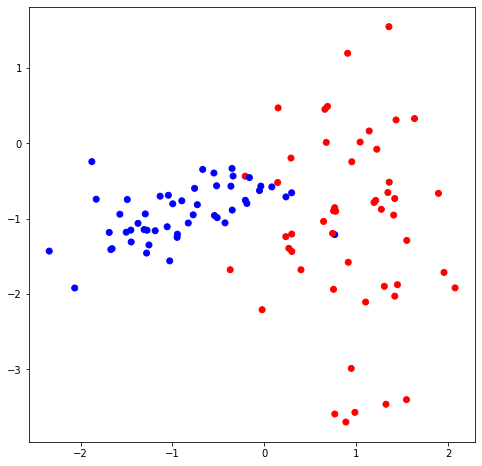

In [239]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [153]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [154]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [155]:
#функция получает список элементов, не попавших в бутстреп

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [156]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [157]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [158]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [159]:
# Расчет энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entrop = 0
    for label in classes:
        p = classes[label] / len(labels)
        entrop -= p *np.log2(p)
        
    return entrop

# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [207]:
# Расчет качества

def quality(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [195]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [196]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [197]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [198]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, bootstrap

In [199]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [200]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [201]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [240]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [203]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [204]:
def get_out_of_bag(data, labels, bootstrap):
    #cписок элементов, не попавших в бутстреп
    oob={} 
    for i in range(len(data)):
        if not data[i] in bootstrap[0]:
            oob.append((data[i], labels[i]))
    return oob

In [205]:
def out_of_bag(data, actual_labels, predicted_labels, bootstrap, my_forest):
    #для каждого примера в массиве входных примеров
    result = 0
    for j in range(len(data)):
        x = data[j]
        sum_y = 0 #обнуляем сумму предсказания для этого примера
        n_y = 0 # количество деревьев, при обучении которых не использовался этот элемент
        for i in range(len(my_forest)): #в каждом дереве
            if (x not in bootstrap[i][0]): #если элемент не использовался при обучении данного дерева             
                y_pred = predicted_labels[j]
                sum_y = sum_y+(y_pred-actual_labels[j])
                n_y += 1
        loss_x = 0           
        if (n_y > 0):
            loss_x = sum_y/n_y
        result =+loss_x
    return result
    

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [241]:
n_trees = 1
my_forest_1, bootstrap_1 = random_forest(train_data, train_labels, n_trees)

In [242]:
# Получим ответы для обучающей выборки 
train_answers_1 = tree_vote(my_forest_1, train_data)

In [243]:
# И получим ответы для тестовой выборки
test_answers_1 = tree_vote(my_forest_1, test_data)

In [244]:
answers = tree_vote(my_forest_1,classification_data)
L = out_of_bag(classification_data, classification_labels, answers, bootstrap_1, my_forest_1)

In [245]:
L

0.0

In [246]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers_1)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 94.286


In [247]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers_1)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 90.000


In [248]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

Построим лес из трех деревьев

In [249]:
n_trees = 3
my_forest_3,bootstrap_3 = random_forest(train_data, train_labels, n_trees)

In [250]:
# Получим ответы для обучающей выборки 
train_answers_3 = tree_vote(my_forest_3, train_data)

In [251]:
# И получим ответы для тестовой выборки
test_answers_3 = tree_vote(my_forest_3, test_data)

In [252]:
answers = tree_vote(my_forest_3,classification_data)
L = out_of_bag(classification_data, classification_labels, answers, bootstrap_3, my_forest_3)

In [253]:
L

0.0

In [254]:
# Точность на обучающей выборке
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_3:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 95.714


In [255]:
# Точность на тестовой выборке
test_accuracy_3 = accuracy_metric(test_labels, test_answers_3)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_3:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 90.000


(20636, 0) (20636, 1) (20636, 1)


<ipython-input-256-5ad14a98d693>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-256-5ad14a98d693>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=90.00')

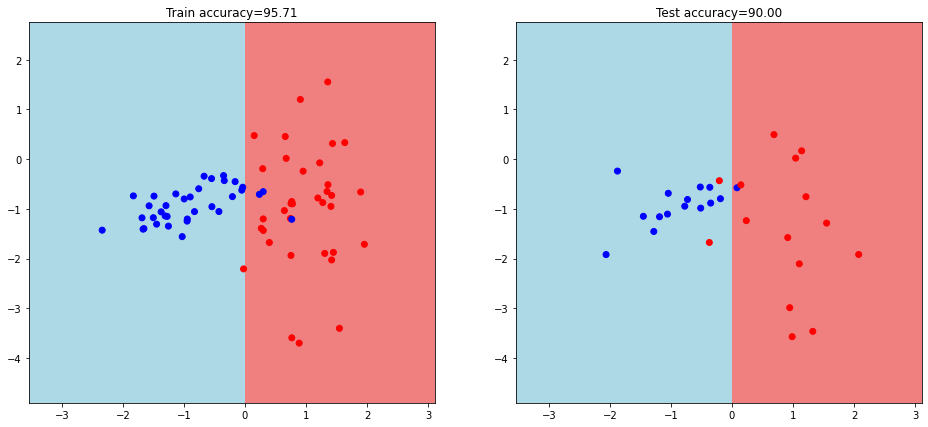

In [256]:


plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_3,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_3:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_3:.2f}')

Построим лес из десяти деревьев

In [257]:
n_trees = 10
my_forest_10, bootstrap_10 = random_forest(train_data, train_labels, n_trees)

In [258]:
# Получим ответы для обучающей выборки 
train_answers_10 = tree_vote(my_forest_10, train_data)

In [259]:
# И получим ответы для тестовой выборки
test_answers_10 = tree_vote(my_forest_10, test_data)

In [260]:
# Точность на обучающей выборке
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_10:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 95.714


In [261]:
# Точность на тестовой выборке
test_accuracy_10 = accuracy_metric(test_labels, test_answers_10)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_10:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 90.000


In [262]:
answers = tree_vote(my_forest_3,classification_data)
L = out_of_bag(classification_data, classification_labels, answers, bootstrap_3, my_forest_3)
L

0.0

(20636, 0) (20636, 1) (20636, 1)


<ipython-input-263-a6fedfe74f64>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-263-a6fedfe74f64>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=90.00')

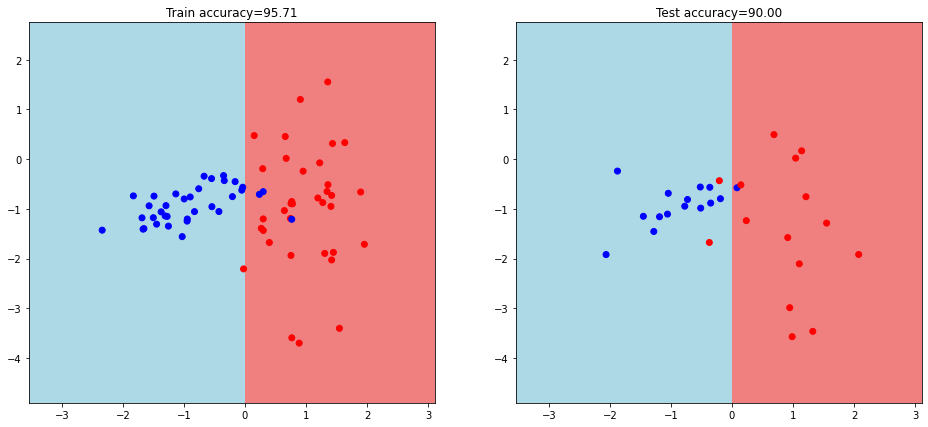

In [263]:

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_10,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_10:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_10:.2f}')

Построим лес из пятидесяти деревьев

In [264]:
n_trees = 50
my_forest_50, bootstrap_50 = random_forest(train_data, train_labels, n_trees)

In [265]:
# Получим ответы для обучающей выборки 
train_answers_50 = tree_vote(my_forest_50, train_data)

In [266]:
# И получим ответы для тестовой выборки
test_answers_50 = tree_vote(my_forest_50, test_data)

In [267]:
# Точность на обучающей выборке
train_accuracy_50 = accuracy_metric(train_labels, train_answers_50)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_50:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 95.714


In [268]:
# Точность на тестовой выборке
test_accuracy_50 = accuracy_metric(test_labels, test_answers_50)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_50:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 90.000


In [ ]:
# Визуализируем дерево на графике


plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_50,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [ ]:
#Построим график для 10 деревьев
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_10,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Как можно увидеть из показателей качества предсказаний, точность случайного леса возрастает при увеличении числа деревьев в нем. Но при этом по точности на тестовой выборке можно сказать, что при увеличении количества деревьев до 50 наш лес переобучается (50 деревьев на 100 объектов - это слишком много все-таки). 

Случайный лес : sklearn.ensemble.RandomForestClassifier -  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Дополнительные материалы

1. [Смещение и разброс](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/)
2. [Бэггинг с точки зрения статистики](https://habr.com/ru/company/ods/blog/324402/#begging)
3. Андреас Мюллер, Сара Гвидо, Введение в машинное обучение с помощью Python. Руководство для специалистов по работе с данными (2016)